In [25]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

#### 2.2. Load Data

In [26]:
# Loading Data 
df_train = pd.read_csv('DataSet/Paitients_Files_Train.csv')
df_test = pd.read_csv('DataSet/Paitients_Files_Test.csv')

print("Train info\n", df_train.info())
print("Test Info\n", df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB
Train info
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null  

**Exploratory Data Analysis (EDA):**

In [27]:
df_train['Sepssis'].unique()

array(['Positive', 'Negative'], dtype=object)

          ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive
              PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.00000

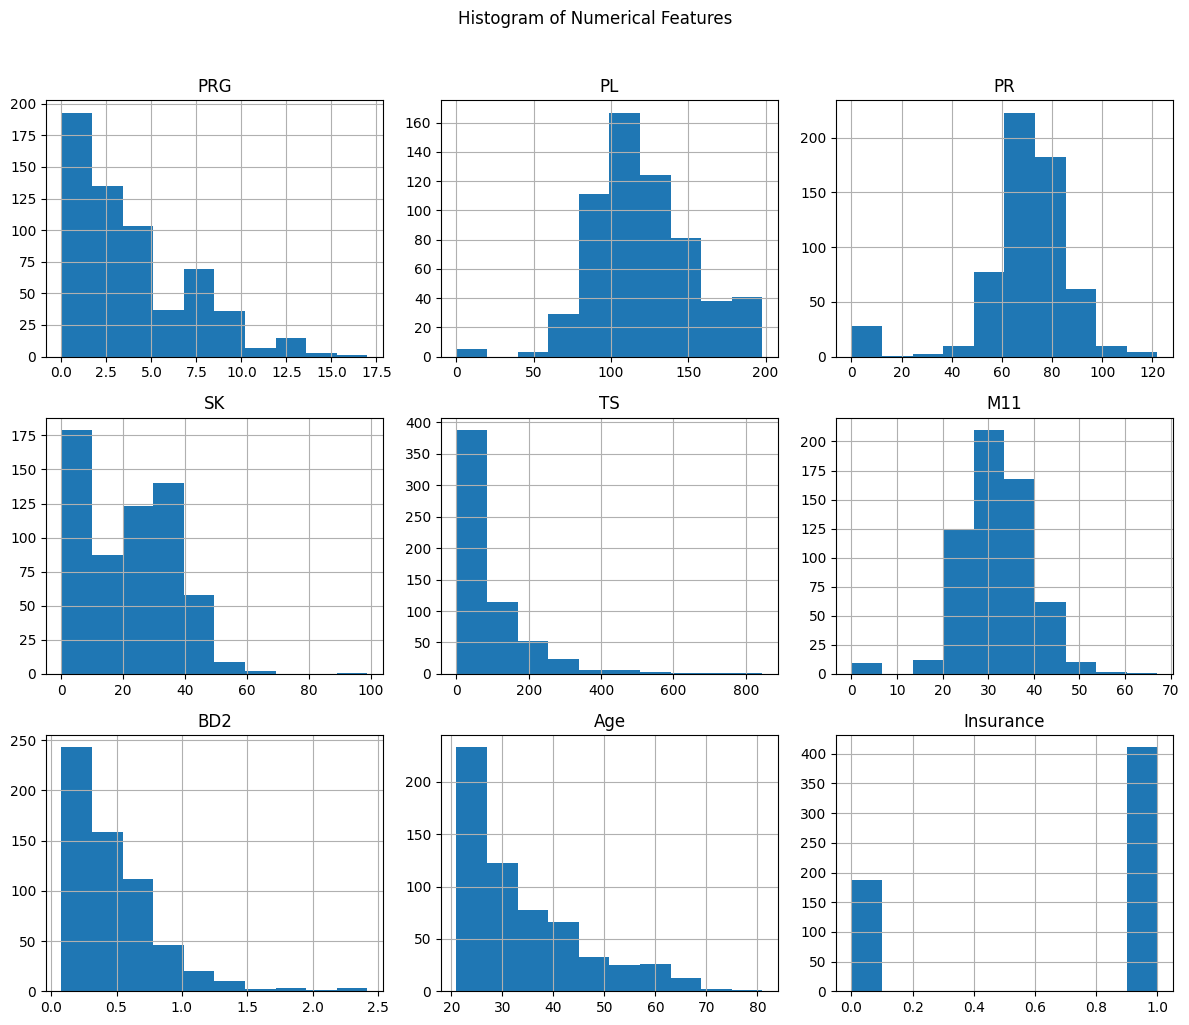

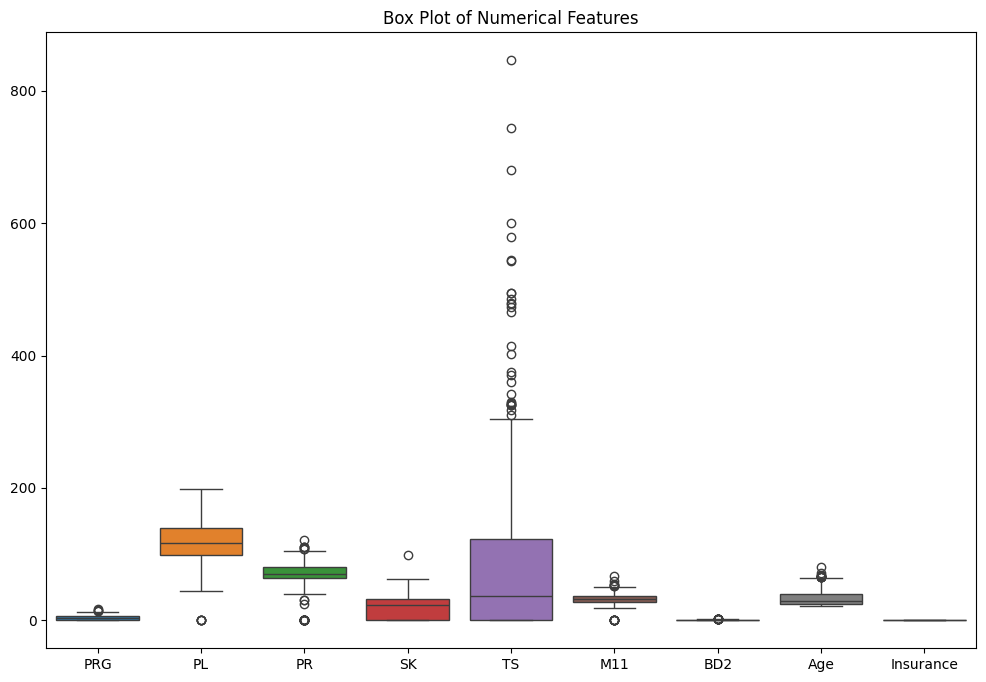

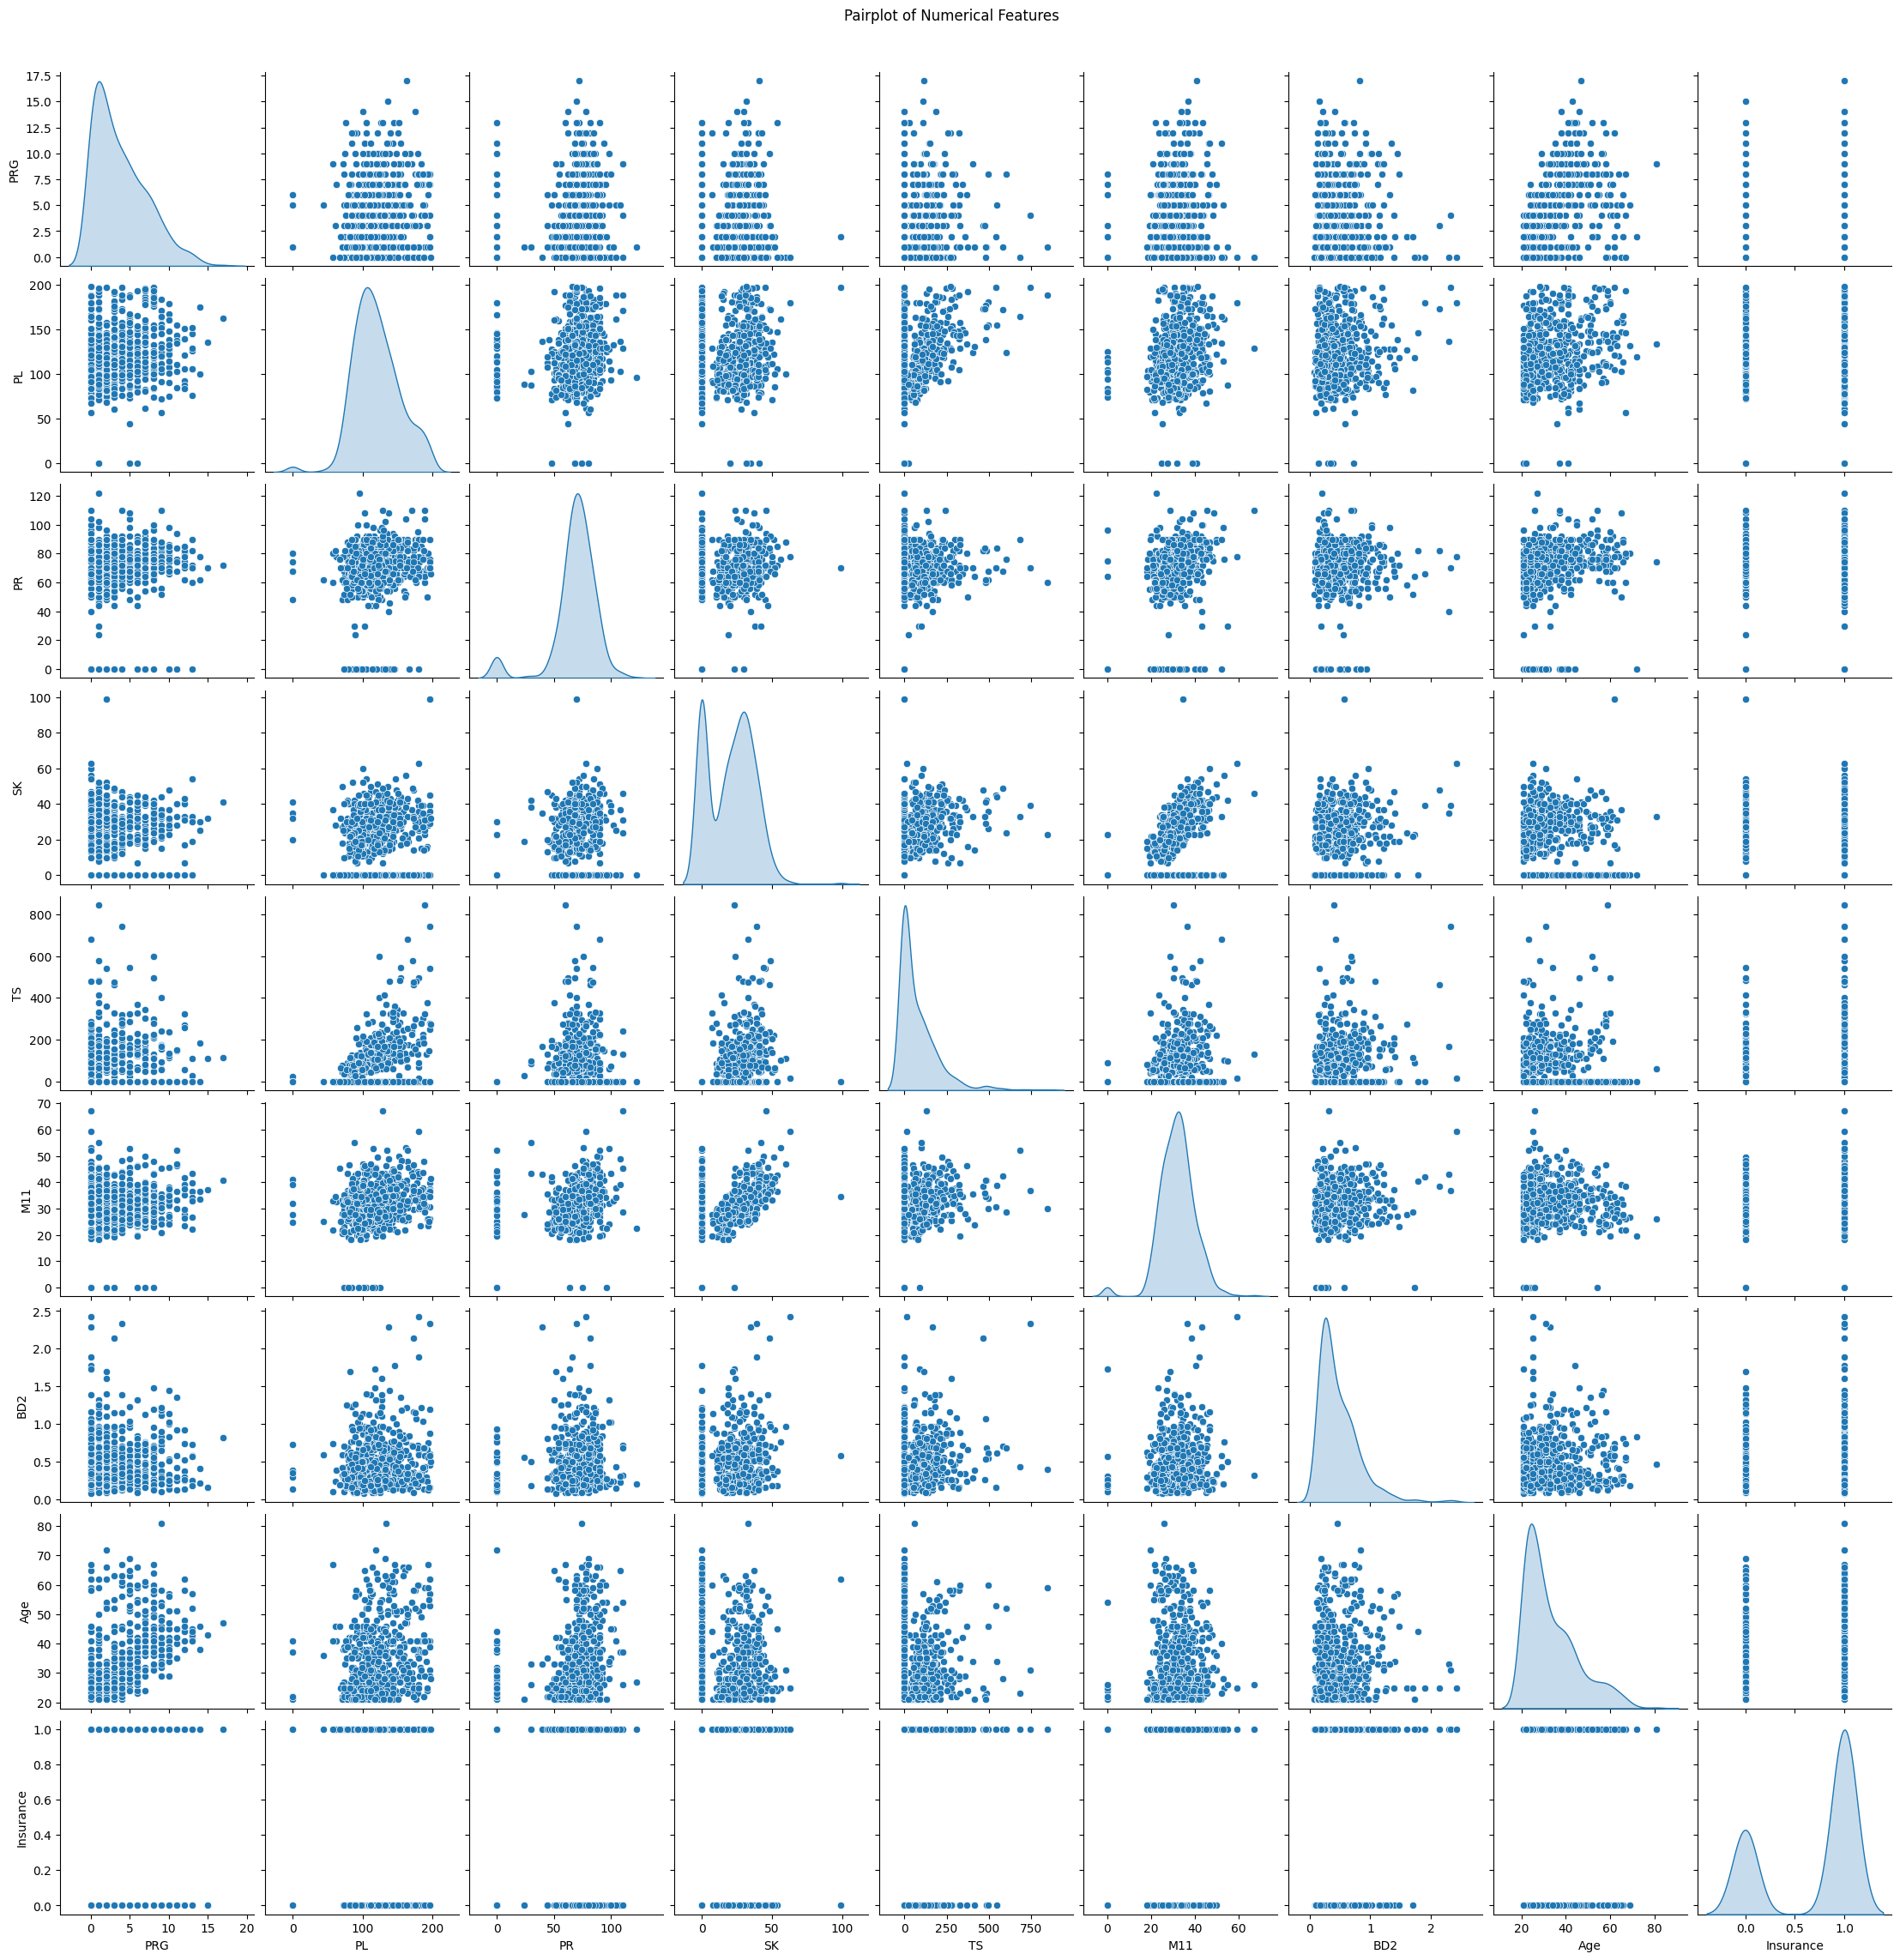

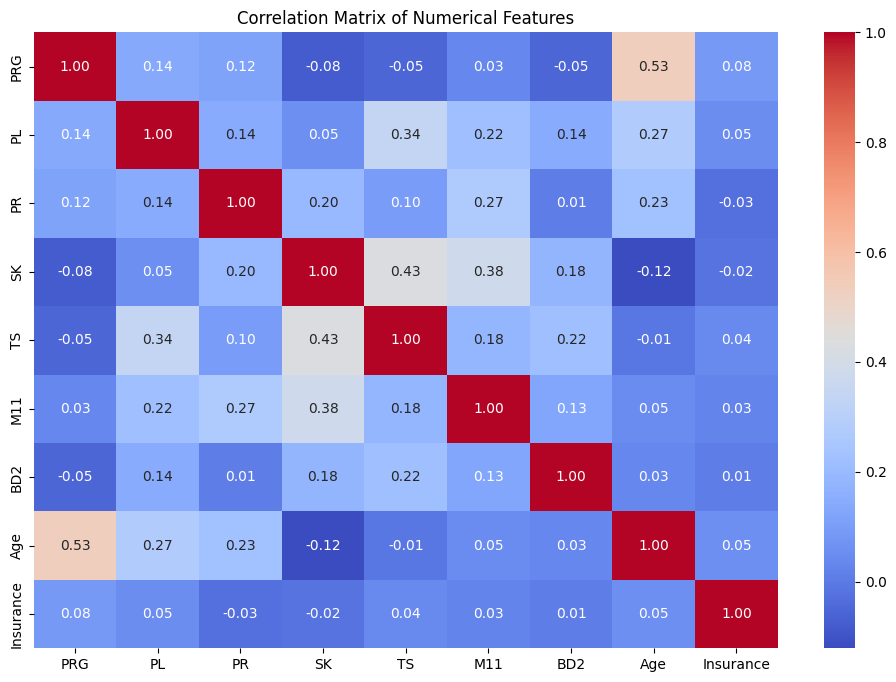

In [28]:
print(df_train.head())
print(df_train.describe())

df_train.hist(figsize=(12, 10))
plt.suptitle('Histogram of Numerical Features', y=1.02)  
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train.drop(columns=['ID']))  
plt.title('Box Plot of Numerical Features')  
plt.show()


sns.pairplot(df_train.drop(columns=['ID']), diag_kind='kde')  
plt.suptitle('Pairplot of Numerical Features', y=1.02)  
plt.show()


plt.figure(figsize=(12, 8))
sns.heatmap(df_train.drop(columns=['ID', 'Sepssis']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')  
plt.show()


In [29]:
def detect_outliers(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns
if 'ID' in numerical_columns:
    numerical_columns = numerical_columns.drop('ID')
if 'Insurance' in numerical_columns:
    numerical_columns = numerical_columns.drop('Insurance')
if 'Sepssis' in numerical_columns:
    numerical_columns = numerical_columns.drop('Sepssis')

outliers_dict = {}
for column in numerical_columns:
    outliers = detect_outliers(df_train[column])
    outliers_dict[column] = outliers

# Print columns with outliers
for column, outliers in outliers_dict.items():
    if outliers.any():  # Check if any outliers exist in the column
        print(f"Outliers in {column}:")
        print(df_train.loc[outliers.index])


Outliers in PRG:
            ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0    ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1    ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2    ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3    ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4    ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive
..         ...  ...  ...  ..  ..  ...   ...    ...  ...        ...       ...
594  ICU200604    6  123  72  45  230  33.6  0.733   34          0  Negative
595  ICU200605    0  188  82  14  185  32.0  0.682   22          1  Positive
596  ICU200606    0   67  76   0    0  45.3  0.194   46          1  Negative
597  ICU200607    1   89  24  19   25  27.8  0.559   21          0  Negative
598  ICU200608    1  173  74   0    0  36.8  0.088   38          1  Positive

[599 rows x 11 columns]
Outliers in PL:
            ID  PR

#### Handling Outliers
we will now apply a logarithmic transformation (`np.log1p`) to these numerical columns, to help normalize the skewed data distributions and mitigate the impact of outliers. This preprocessing step prepares the data for machine learning modeling by making it more suitable for analysis and modeling.

In [30]:
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).drop(columns=['ID', 'Insurance', 'Sepssis'], errors='ignore').columns
df_train[numerical_columns] = df_train[numerical_columns].apply(lambda x: np.log1p(x))
print(df_train[numerical_columns])


          PRG        PL        PR        SK        TS       M11       BD2  \
0    1.945910  5.003946  4.290459  3.583519  0.000000  3.543854  0.486738   
1    0.693147  4.454347  4.204693  3.401197  0.000000  3.317816  0.300845   
2    2.197225  5.214936  4.174387  0.000000  0.000000  3.190476  0.514021   
3    0.693147  4.499810  4.204693  3.178054  4.553877  3.370738  0.154436   
4    0.000000  4.927254  3.713572  3.583519  5.129899  3.786460  1.190279   
..        ...       ...       ...       ...       ...       ...       ...   
594  1.945910  4.820282  4.290459  3.828641  5.442418  3.543854  0.549854   
595  0.000000  5.241747  4.418841  2.708050  5.225747  3.496508  0.519984   
596  0.000000  4.219508  4.343805  0.000000  0.000000  3.835142  0.177309   
597  0.693147  4.499810  3.218876  2.995732  3.258097  3.360375  0.444045   
598  0.693147  5.159055  4.317488  0.000000  0.000000  3.632309  0.084341   

          Age  
0    3.931826  
1    3.465736  
2    3.496508  
3    3.0910

**Data Preprocessing:** 

We first separate the features (X) and the target variable (y). Then, we define separate preprocessing steps for numerical and categorical features. For numerical features, we impute missing values with the mean and standardize the features. For categorical features, we impute missing values with a constant value ('missing') and encode the categorical variables using one-hot encoding. Finally, we combine these preprocessing steps using the ColumnTransformer and apply them to the features (X) to get the preprocessed data (X_preprocessed).

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df_train.drop(columns=['ID'])
y = df_train['ID']


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)


**Feature Engineering:**

Next, we use the PolynomialFeatures transformer from scikit-learn to create interaction terms and polynomial features from the preprocessed feature matrix (X_preprocessed). The degree parameter specifies the degree of the polynomial features to generate. Setting interaction_only=True creates only interaction terms (e.g., product of two features), while setting it to False generates all polynomial combinations up to the specified degree.

In [32]:
from sklearn.preprocessing import PolynomialFeatures
interaction_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = interaction_transformer.fit_transform(X_preprocessed)

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_transformer.fit_transform(X_preprocessed)

In [33]:
# Convert 'Sepssis' column to 0 and 1
df_train['Sepssis'] = df_train['Sepssis'].replace({'Negative': 0, 'Positive': 1})

# Check the updated column
print(df_train['Sepssis'])


0      1
1      0
2      1
3      0
4      1
      ..
594    0
595    1
596    0
597    0
598    1
Name: Sepssis, Length: 599, dtype: int64


C:\Users\Hp\AppData\Local\Temp\ipykernel_11564\1637797497.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Sepssis'] = df_train['Sepssis'].replace({'Negative': 0, 'Positive': 1})


In [34]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns=['Sepssis', 'ID'])
y = df_train['Sepssis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (479, 9) (479,)
Testing set shape: (120, 9) (120,)


#### Creating the Metric Table

Next we create a metrics table with evaluation metrics for a the given model. It takes as input the current metrics DataFrame (metrics_df), the name of the model (model_name), the true labels (y_test), and the predicted labels (y_pred). It calculates various metrics such as accuracy, precision, recall, F1-score, and ROC-AUC score using functions from scikit-learn. It then creates a new row containing these metrics for the model and appends it to the metrics DataFrame. If the metrics DataFrame is empty, it initializes it with the new row. Finally, it returns the updated metrics DataFrame.

In [37]:
def update_metrics(metrics_df, model_name, y_test, y_pred):
    """
    Update the metrics table with the evaluation metrics for a given model.

    Parameters:
        metrics_df (DataFrame): The DataFrame containing the metrics table.
        model_name (str): The name of the model.
        y_test (array-like): The true labels.
        y_pred (array-like): The predicted labels.

    Returns:
        DataFrame: The updated metrics table.
    """
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    new_row = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1-score': [f1],
        'ROC-AUC': [roc_auc]
    })

    if metrics_df.empty:
        metrics_df = new_row
    else:
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)
    return metrics_df


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'Logistic Regression', y_test, y_pred)
print(metrics_df)



                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667     0.6875  0.511628  0.586667  0.690879


In [41]:
from sklearn.ensemble import RandomForestClassifier

# Assuming the update_metrics function is defined as before

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'Random Forest', y_test, y_pred)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667   0.687500  0.511628  0.586667  0.690879
1        Random Forest  0.700000   0.577778  0.604651  0.590909  0.678949


In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Assuming the update_metrics function is defined as before

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'Gradient Boosting', y_test, y_pred)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667   0.687500  0.511628  0.586667  0.690879
1        Random Forest  0.700000   0.577778  0.604651  0.590909  0.678949
2    Gradient Boosting  0.766667   0.666667  0.697674  0.681818  0.751435


In [43]:
from sklearn.svm import SVC

# Assuming the update_metrics function is defined as before

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'SVM', y_test, y_pred)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667   0.687500  0.511628  0.586667  0.690879
1        Random Forest  0.700000   0.577778  0.604651  0.590909  0.678949
2    Gradient Boosting  0.766667   0.666667  0.697674  0.681818  0.751435
3                  SVM  0.666667   0.578947  0.255814  0.354839  0.575959


In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming the update_metrics function is defined as before

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'K-Nearest Neighbors', y_test, y_pred)
print(metrics_df)



                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667   0.687500  0.511628  0.586667  0.690879
1        Random Forest  0.700000   0.577778  0.604651  0.590909  0.678949
2    Gradient Boosting  0.766667   0.666667  0.697674  0.681818  0.751435
3                  SVM  0.666667   0.578947  0.255814  0.354839  0.575959
4  K-Nearest Neighbors  0.625000   0.475000  0.441860  0.457831  0.584567


In [45]:
from sklearn.tree import DecisionTreeClassifier

# Assuming the update_metrics function is defined as before

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics_df = update_metrics(metrics_df, 'Decision Tree', y_test, y_pred)
print(metrics_df)

                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.741667   0.687500  0.511628  0.586667  0.690879
1        Random Forest  0.700000   0.577778  0.604651  0.590909  0.678949
2    Gradient Boosting  0.766667   0.666667  0.697674  0.681818  0.751435
3                  SVM  0.666667   0.578947  0.255814  0.354839  0.575959
4  K-Nearest Neighbors  0.625000   0.475000  0.441860  0.457831  0.584567
5        Decision Tree  0.700000   0.589744  0.534884  0.560976  0.663546


Based on these metrics, Gradient Boosting appears to perform the best overall, with the highest accuracy and F1-score among the models listed. SVM performs the worst in terms of both accuracy and recall.

#### Training the best model

In [53]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

best_model = GradientBoostingClassifier()
best_model.fit(X_train, y_train)

metrics_df.to_csv(os.path.join(models_dir, 'metrics.csv'), index=False)

score = best_model.score(X_test, y_test)
print(f"Model score: {score}")

params = best_model.get_params()
print(f"Model parameters: {params}")

feature_importances = best_model.feature_importances_
print(f"Feature importances: {feature_importances}")

classes = best_model.classes_
print(f"Model classes: {classes}")

y_pred = best_model.predict(X_test)
print(f"Predictions: {y_pred}")

pd.DataFrame(y_pred, columns=['Sepssis_Prediction']).to_csv(os.path.join(models_dir, 'Sepssis_Prediction.csv'), index=False)

print(f"Predictions are equal: {np.array_equal(y_pred, best_model.predict(X_test))}")


Model score: 0.7583333333333333
Model parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Feature importances: [0.06219731 0.3666035  0.02246258 0.04524046 0.06561073 0.23702194
 0.09803269 0.09730805 0.00552274]
Model classes: [0 1]
Predictions: [1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1]
Predictions are equal: True
